In [49]:
import cv2
import pandas as pd
import numpy as np
import os
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import cpu_count
import concurrent.futures
import time
from tqdm.notebook import tqdm

In [41]:
def background_subtraction(fish_video_path, background_video_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the video files
    fish_cap = cv2.VideoCapture(fish_video_path)
    if not fish_cap.isOpened():
        print("Fish video could not be opened")
        return
    print("Fish video opened successfully")
    
    bg_cap = cv2.VideoCapture(background_video_path)
    if not bg_cap.isOpened():
        print("Background video could not be opened")
        return
    print("Background video opened successfully")
    
    # Get properties of the fish video
    width = int(fish_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(fish_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(fish_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Read a single frame from the background video
    ret, bg_frame = bg_cap.read()
    if not ret:
        print("Error: Could not read frame from background video")
        return
    
    # Resize background frame if needed
    if (bg_frame.shape[1], bg_frame.shape[0]) != (width, height):
        bg_frame = cv2.resize(bg_frame, (width, height))
    
    # Convert background to grayscale once
    bg_gray = cv2.cvtColor(bg_frame, cv2.COLOR_BGR2GRAY)
    
    print(f"Processing {frame_count} frames...")
    
    # Setup the display figure
    plt.figure(figsize=(12, 6))
    
    # Process each frame from the fish video
    frame_idx = 0
    while True:
        ret, fish_frame = fish_cap.read()
        if not ret:
            break
        
        # Convert current frame to grayscale
        fish_gray = cv2.cvtColor(fish_frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate absolute difference
        diff = cv2.absdiff(fish_gray, bg_gray)
        
        # Apply threshold to get binary image
        _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
        
        # Noise removal using morphological operations
        kernel = np.ones((5,5), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        # Create a 3-channel binary mask
        mask = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        
        # Apply the mask to the original fish frame to isolate the fish
        result = cv2.bitwise_and(fish_frame, mask)
        
        # Save the frame as an image
        output_path = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
        cv2.imwrite(output_path, result)
        
        # Display every 10th frame to avoid slowing down the notebook too much
        if frame_idx % 10 == 0:
            clear_output(wait=True)
            
            # Convert BGR to RGB for matplotlib
            fish_rgb = cv2.cvtColor(fish_frame, cv2.COLOR_BGR2RGB)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
            
            # Display the images side by side
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(fish_rgb)
            plt.title('Original Frame')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(result_rgb)
            plt.title('Background Subtracted')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"Processing frame {frame_idx}/{frame_count}")
        
        frame_idx += 1
    
    # Release resources
    fish_cap.release()
    bg_cap.release()
    
    print(f"Background subtraction completed! {frame_idx} frames saved to {output_folder}")



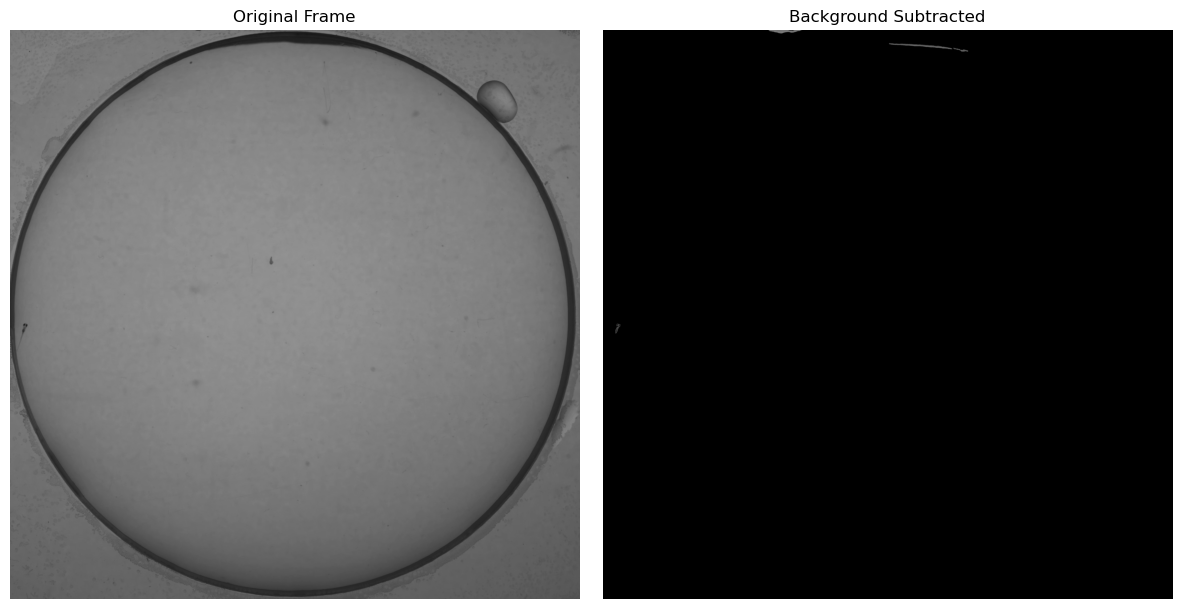

Processing frame 5450/5457
Background subtraction completed! 5454 frames saved to fish_frames


In [42]:
fish_video_path = "one_fish.mp4"
background_video_path = "empty_dish.mp4"
output_folder = "fish_frames"
    
background_subtraction(fish_video_path, background_video_path, output_folder)

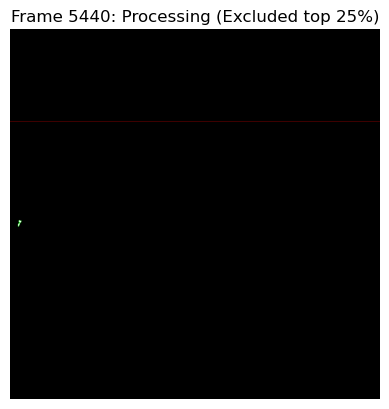

Processed frame 5440/5459
Centroid data saved to fish_trajectory.csv


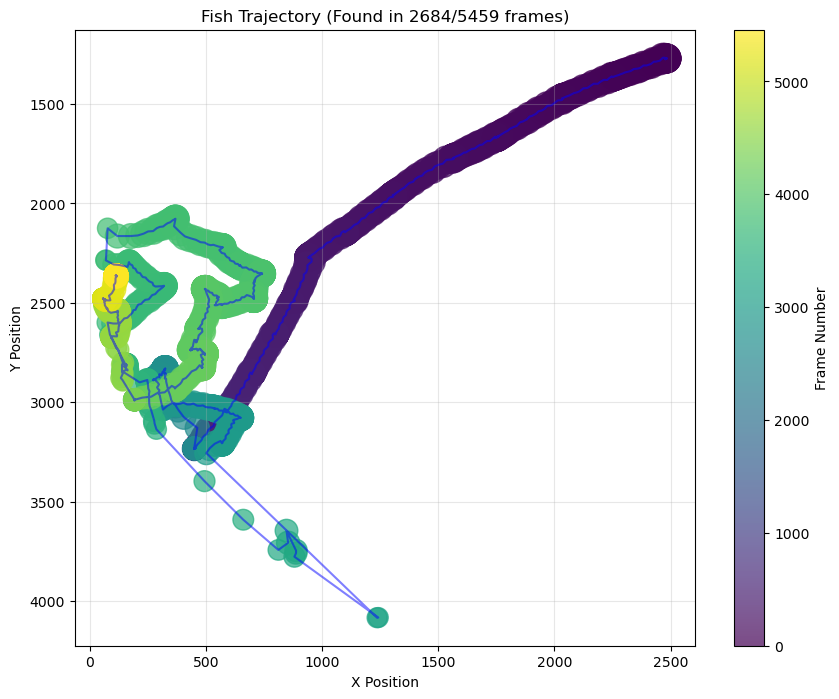

In [43]:
def extract_centroids(input_folder, output_csv, min_area=50, max_area=1000, exclude_top_ratio=0.33):
    # Get all image files from the folder, sorted by frame number
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
    
    # Prepare data storage
    frame_data = []
    
    # Setup visualization
    plt.figure(figsize=(10, 8))
    
    # Process each image
    for i, image_file in enumerate(image_files):
        # Load the image
        img_path = os.path.join(input_folder, image_file)
        img = cv2.imread(img_path)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate the top exclusion zone
        exclude_height = int(img.shape[0] * exclude_top_ratio)
        
        # Create a mask to exclude the top portion of the image
        mask = np.ones_like(gray, dtype=np.uint8) * 255
        mask[0:exclude_height, :] = 0  # Set top part of the mask to black
        
        # Apply the mask to the grayscale image
        masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
        
        # Apply additional preprocessing
        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(masked_gray, cv2.MORPH_OPEN, kernel)
        
        # Apply thresholding
        _, binary = cv2.threshold(cleaned, 20, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by area
        fish_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if min_area < area < max_area:
                # Additional check: make sure centroid is not in excluded zone
                M = cv2.moments(contour)
                if M["m00"] > 0:
                    cy = int(M["m01"] / M["m00"])
                    if cy >= exclude_height:  # Only include if below excluded zone
                        fish_contours.append(contour)
        
        # Create a visualization image
        vis_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        
        # Draw exclusion zone line
        cv2.line(vis_img, (0, exclude_height), (img.shape[1], exclude_height), (0, 0, 255), 2)
        
        # If fish contours found
        found_fish = False
        if fish_contours:
            # For simplicity, use the largest remaining contour as the fish
            largest_contour = max(fish_contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            # Store data
            frame_data.append({
                'frame': i,
                'x': cx,
                'y': cy,
                'area': cv2.contourArea(largest_contour)
            })
            
            # Mark the fish contour in green
            cv2.drawContours(vis_img, [largest_contour], -1, (0, 255, 0), 2)
            
            # Mark the fish centroid in bright green
            cv2.circle(vis_img, (cx, cy), 7, (0, 255, 0), -1)
            
            found_fish = True
        
        if not found_fish:
            print(f"No suitable fish contour found in frame {i}")
            frame_data.append({
                'frame': i,
                'x': None,
                'y': None,
                'area': 0
            })
        
        # Display every 20th frame to check progress
        if i % 20 == 0:
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {i}: Processing (Excluded top {exclude_top_ratio*100:.0f}%)")
            plt.axis('off')
            plt.show()
            print(f"Processed frame {i}/{len(image_files)}")
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(frame_data)
    df.to_csv(output_csv, index=False)
    print(f"Centroid data saved to {output_csv}")
    
    return df

def plot_trajectory(df):
    # Plot fish trajectory
    plt.figure(figsize=(10, 8))
    
    # Filter out rows where x and y are not None
    valid_data = df.dropna(subset=['x', 'y'])
    
    if len(valid_data) > 0:
        # Plot trajectory
        plt.plot(valid_data['x'], valid_data['y'], 'b-', alpha=0.5)
        plt.scatter(valid_data['x'], valid_data['y'], c=valid_data['frame'], 
                    cmap='viridis', s=valid_data['area']/5, alpha=0.7)
        
        plt.colorbar(label='Frame Number')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Fish Trajectory (Found in {len(valid_data)}/{len(df)} frames)')
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "No valid fish tracking data found", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=14)
    
    plt.show()

# Usage
input_folder = "fish_frames"  # Your folder of processed images
output_csv = "fish_trajectory.csv"

# Parameters
min_fish_area = 1000       # Minimum area in pixels
max_fish_area = 4000     # Maximum area in pixels
exclude_top_ratio = 0.25  # Exclude top 33% of the image

# Extract centroids and get the DataFrame
df = extract_centroids(input_folder, output_csv, 
                      min_area=min_fish_area, 
                      max_area=max_fish_area,
                      exclude_top_ratio=exclude_top_ratio)


# Plot the trajectory
plot_trajectory(df)

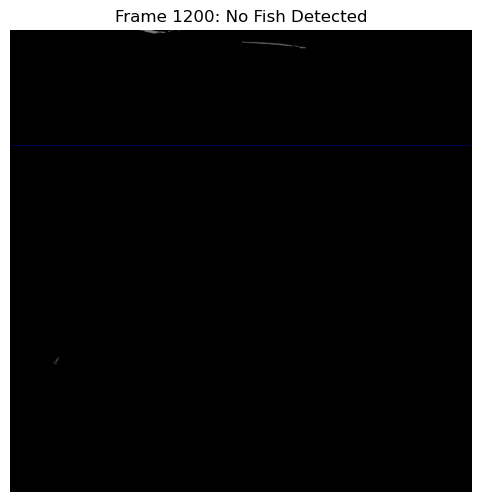

Processed frame 1200/5459
No suitable fish contour found in frame 1208
No suitable fish contour found in frame 1209
No suitable fish contour found in frame 1210
No suitable fish contour found in frame 1211
No suitable fish contour found in frame 1212
No suitable fish contour found in frame 1213
No suitable fish contour found in frame 1214
No suitable fish contour found in frame 1215
No suitable fish contour found in frame 1216
No suitable fish contour found in frame 1217
No suitable fish contour found in frame 1218


KeyboardInterrupt: 

In [46]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def extract_centroids_with_bounding_box(input_folder, output_csv, crops_folder, min_area=50, max_area=1000, exclude_top_ratio=0.33):
    # Create output folder for crops if it doesn't exist
    if not os.path.exists(crops_folder):
        os.makedirs(crops_folder)
    
    # Get all image files from the folder, sorted by frame number
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
    
    # Prepare data storage
    frame_data = []
    
    # Process each image
    for i, image_file in enumerate(image_files):
        # Load the image
        img_path = os.path.join(input_folder, image_file)
        img = cv2.imread(img_path)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate the top exclusion zone
        exclude_height = int(img.shape[0] * exclude_top_ratio)
        
        # Create a mask to exclude the top portion of the image
        mask = np.ones_like(gray, dtype=np.uint8) * 255
        mask[0:exclude_height, :] = 0  # Set top part of the mask to black
        
        # Apply the mask to the grayscale image
        masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
        
        # Apply additional preprocessing
        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(masked_gray, cv2.MORPH_OPEN, kernel)
        
        # Apply thresholding
        _, binary = cv2.threshold(cleaned, 20, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by area
        fish_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if min_area < area < max_area:
                # Additional check: make sure centroid is not in excluded zone
                M = cv2.moments(contour)
                if M["m00"] > 0:
                    cy = int(M["m01"] / M["m00"])
                    if cy >= exclude_height:  # Only include if below excluded zone
                        fish_contours.append(contour)
        
        # Create a visualization image
        vis_img = img.copy()
        
        # Draw exclusion zone line
        cv2.line(vis_img, (0, exclude_height), (img.shape[1], exclude_height), (255, 0, 0), 2)
        
        # If fish contours found
        found_fish = False
        if fish_contours:
            # For simplicity, use the largest remaining contour as the fish
            largest_contour = max(fish_contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            # Get the bounding rectangle
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            # Add a small margin (5 pixels on each side)
            margin = 5
            crop_x = max(0, x - margin)
            crop_y = max(0, y - margin)
            crop_w = min(img.shape[1] - crop_x, w + 2*margin)
            crop_h = min(img.shape[0] - crop_y, h + 2*margin)
            
            # Crop the fish region
            cropped_img = img[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
            
            # Save the cropped image
            crop_filename = f"fish_crop_{i:04d}.png"
            crop_path = os.path.join(crops_folder, crop_filename)
            cv2.imwrite(crop_path, cropped_img)
            
            # Get a tight bounding box (rotated rectangle) for visualization
            rect = cv2.minAreaRect(largest_contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            # Store data
            frame_data.append({
                'frame': i,
                'x': cx,
                'y': cy,
                'area': cv2.contourArea(largest_contour),
                'bbox_x': crop_x,
                'bbox_y': crop_y,
                'bbox_width': crop_w,
                'bbox_height': crop_h,
                'crop_file': crop_filename
            })
            
            # Draw the fish contour
            cv2.drawContours(vis_img, [largest_contour], -1, (0, 255, 0), 2)
            
            # Draw the bounding rectangle
            cv2.rectangle(vis_img, (crop_x, crop_y), (crop_x+crop_w, crop_y+crop_h), (0, 255, 255), 2)
            
            # Draw the rotated bounding box (tight-fitting)
            cv2.drawContours(vis_img, [box], 0, (255, 0, 255), 2)
            
            # Draw the centroid
            cv2.circle(vis_img, (cx, cy), 5, (0, 0, 255), -1)
            
            found_fish = True
        
        if not found_fish:
            print(f"No suitable fish contour found in frame {i}")
            frame_data.append({
                'frame': i,
                'x': None,
                'y': None,
                'area': 0,
                'bbox_x': None,
                'bbox_y': None,
                'bbox_width': None,
                'bbox_height': None,
                'crop_file': None
            })
        
        # Display progress with both the original image and crop if available
        if i % 20 == 0:
            clear_output(wait=True)
            
            if found_fish:
                # Setup a figure with two subplots
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                # Show the full image with bounding box
                ax1.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                ax1.set_title(f"Frame {i}: Full Image")
                ax1.axis('off')
                
                # Show the cropped image
                ax2.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
                ax2.set_title("Cropped Fish")
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
            else:
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Frame {i}: No Fish Detected")
                plt.axis('off')
                plt.show()
                
            print(f"Processed frame {i}/{len(image_files)}")
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(frame_data)
    df.to_csv(output_csv, index=False)
    print(f"Centroid and bounding box data saved to {output_csv}")
    print(f"Cropped images saved to {crops_folder}")
    
    return df

def analyze_crops(crops_folder, df):
    # Plot some statistics about the crops
    valid_data = df.dropna(subset=['crop_file'])
    
    if len(valid_data) > 0:
        plt.figure(figsize=(12, 8))
        
        # Plot 1: Crop dimensions
        plt.subplot(2, 2, 1)
        plt.scatter(valid_data['bbox_width'], valid_data['bbox_height'], 
                    c=valid_data['frame'], cmap='viridis', alpha=0.7)
        plt.colorbar(label='Frame')
        plt.xlabel('Width (pixels)')
        plt.ylabel('Height (pixels)')
        plt.title('Crop Dimensions')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Crop area over time
        plt.subplot(2, 2, 2)
        plt.plot(valid_data['frame'], valid_data['bbox_width'] * valid_data['bbox_height'])
        plt.xlabel('Frame')
        plt.ylabel('Crop Area (pixels²)')
        plt.title('Crop Size Over Time')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Sample crops
        plt.subplot(2, 1, 2)
        
        # Show a sample of cropped images
        n_samples = min(5, len(valid_data))
        sample_indices = np.linspace(0, len(valid_data)-1, n_samples, dtype=int)
        
        for i, idx in enumerate(sample_indices):
            crop_file = valid_data.iloc[idx]['crop_file']
            frame_num = valid_data.iloc[idx]['frame']
            crop_path = os.path.join(crops_folder, crop_file)
            
            if os.path.exists(crop_path):
                crop_img = cv2.imread(crop_path)
                if crop_img is not None:
                    plt.subplot(2, n_samples, n_samples + i + 1)
                    plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Frame {frame_num}")
                    plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Successfully created and saved {len(valid_data)} cropped images")
    else:
        print("No valid crop data found")

# Usage
input_folder = "fish_frames"      # Your folder of processed images
output_csv = "fish_trajectory_with_crops.csv"
crops_folder = "fish_crops"       # Folder for saving cropped images

# Parameters
min_fish_area = 1000        # Minimum area in pixels
max_fish_area = 4000      # Maximum area in pixels
exclude_top_ratio = 0.25

# Extract centroids and get the DataFrame with crops
df = extract_centroids_with_bounding_box(input_folder, output_csv, crops_folder,
                                        min_area=min_fish_area, 
                                        max_area=max_fish_area,
                                        exclude_top_ratio=exclude_top_ratio)

# Analyze the cropped images
analyze_crops(crops_folder, df)

In [50]:
def process_single_frame(args):
    """Process a single frame to detect and crop the fish"""
    image_file, i, input_folder, crops_folder, min_area, max_area, exclude_top_ratio = args
    
    # Load the image
    img_path = os.path.join(input_folder, image_file)
    img = cv2.imread(img_path)
    
    if img is None:
        return {
            'frame': i,
            'x': None,
            'y': None,
            'area': 0,
            'bbox_x': None,
            'bbox_y': None,
            'bbox_width': None,
            'bbox_height': None,
            'crop_file': None,
            'success': False
        }
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the top exclusion zone
    exclude_height = int(img.shape[0] * exclude_top_ratio)
    
    # Create a mask to exclude the top portion of the image
    mask = np.ones_like(gray, dtype=np.uint8) * 255
    mask[0:exclude_height, :] = 0  # Set top part of the mask to black
    
    # Apply the mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    
    # Apply preprocessing - first use a more aggressive threshold
    _, binary = cv2.threshold(masked_gray, 15, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations to fill holes and connect parts
    # Use a larger kernel for dilation to connect separated parts
    kernel_dilate = np.ones((5,5), np.uint8)
    kernel_close = np.ones((7,7), np.uint8)
    
    # Dilate to expand bright regions
    dilated = cv2.dilate(binary, kernel_dilate, iterations=1)
    
    # Close to fill gaps between nearby white regions
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel_close, iterations=2)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area
    fish_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Additional check: make sure centroid is not in excluded zone
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cy = int(M["m01"] / M["m00"])
                if cy >= exclude_height:  # Only include if below excluded zone
                    fish_contours.append(contour)
    
    # If fish contours found
    if fish_contours:
        # Use the largest remaining contour as the fish
        largest_contour = max(fish_contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        
        # Get the bounding rectangle
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Add a small margin (5 pixels on each side)
        margin = 5
        crop_x = max(0, x - margin)
        crop_y = max(0, y - margin)
        crop_w = min(img.shape[1] - crop_x, w + 2*margin)
        crop_h = min(img.shape[0] - crop_y, h + 2*margin)
        
        # Optional: Create an enhanced version of the crop with the original
        # and segmented fish side by side
        cropped_img = img[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
        
        # Add option to save the enhanced debugging image showing the binary
        debug_img = np.zeros_like(cropped_img)
        crop_mask = closed[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]
        crop_mask_rgb = cv2.cvtColor(crop_mask, cv2.COLOR_GRAY2BGR)
        debug_img = np.hstack((cropped_img, crop_mask_rgb))
        
        # Save the cropped image
        crop_filename = f"fish_crop_{i:04d}.png"
        crop_path = os.path.join(crops_folder, crop_filename)
        cv2.imwrite(crop_path, cropped_img)
        
        # Optionally save debug image
        debug_dir = os.path.join(crops_folder, "debug")
        if not os.path.exists(debug_dir):
            os.makedirs(debug_dir)
        debug_path = os.path.join(debug_dir, f"debug_{i:04d}.png")
        cv2.imwrite(debug_path, debug_img)
        
        return {
            'frame': i,
            'x': cx,
            'y': cy,
            'area': cv2.contourArea(largest_contour),
            'bbox_x': crop_x,
            'bbox_y': crop_y,
            'bbox_width': crop_w,
            'bbox_height': crop_h,
            'crop_file': crop_filename,
            'success': True
        }
    else:
        return {
            'frame': i,
            'x': None,
            'y': None,
            'area': 0,
            'bbox_x': None,
            'bbox_y': None,
            'bbox_width': None,
            'bbox_height': None,
            'crop_file': None,
            'success': False
        }

Found 5454 images to process


Processing frames:   0%|          | 0/5454 [00:00<?, ?it/s]

Processing completed in 219.96 seconds (24.80 frames/second)
Detected fish in 5122 out of 5454 frames
Results saved to fish_trajectory_multithreaded.csv
Crops saved to fish_crops_mt


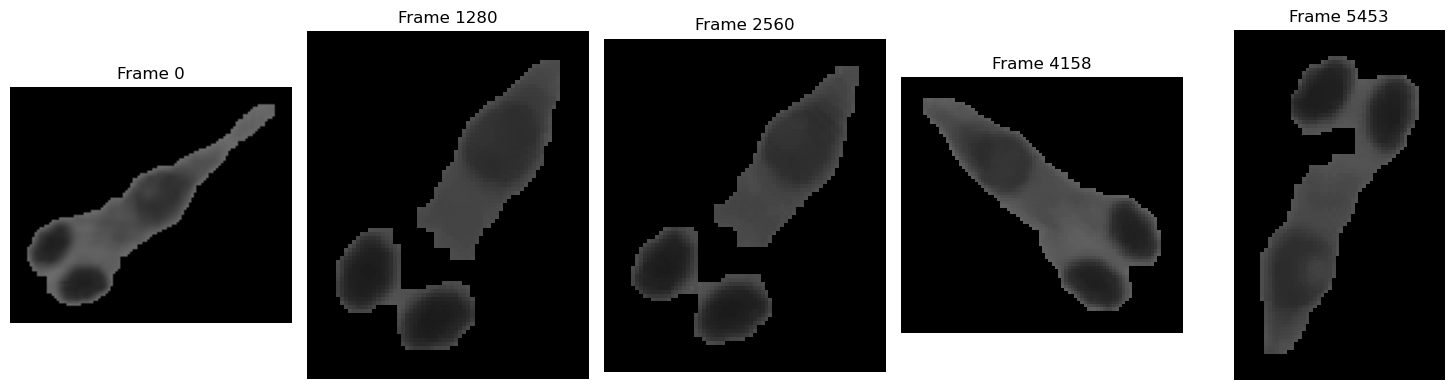

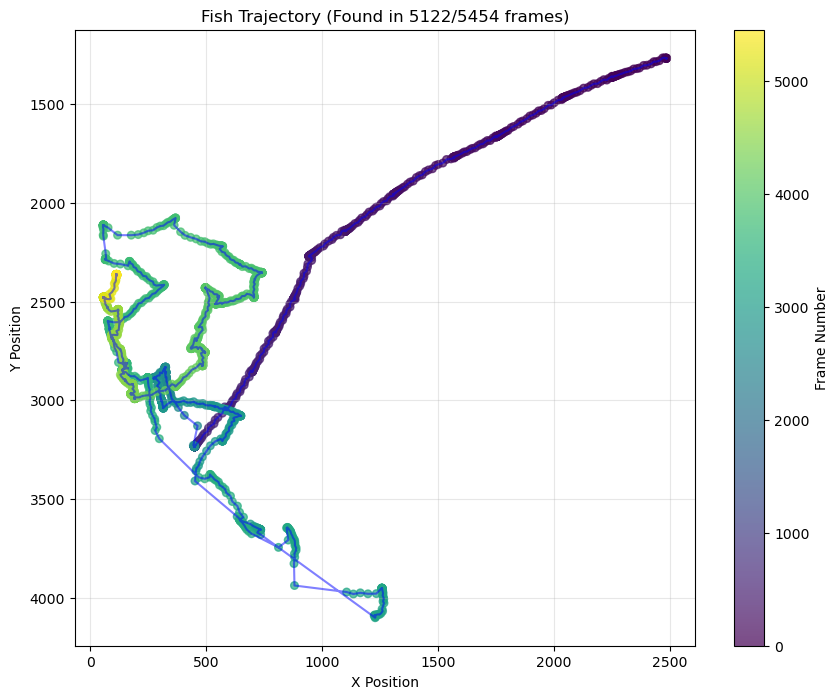

In [52]:
def extract_centroids_multithreaded(input_folder, output_csv, crops_folder, min_area=50, max_area=1000, exclude_top_ratio=0.33, max_workers=8):
    """Process all frames using multiple threads for faster execution"""
    # Create output folder for crops if it doesn't exist
    if not os.path.exists(crops_folder):
        os.makedirs(crops_folder)
    
    # Get all image files from the folder, sorted by frame number
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.png')])
    
    print(f"Found {len(image_files)} images to process")
    
    # Prepare arguments for parallel processing
    args_list = [(image_files[i], i, input_folder, crops_folder, min_area, max_area, exclude_top_ratio) 
                 for i in range(len(image_files))]
    
    # Process frames in parallel
    start_time = time.time()
    results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Process images in batches to show progress
        futures = {executor.submit(process_single_frame, args): i for i, args in enumerate(args_list)}
        
        # Use tqdm for a progress bar
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing frames"):
            results.append(future.result())
    
    # Sort results by frame number
    results.sort(key=lambda x: x['frame'])
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    
    end_time = time.time()
    elapsed = end_time - start_time
    frames_per_second = len(image_files) / elapsed
    
    print(f"Processing completed in {elapsed:.2f} seconds ({frames_per_second:.2f} frames/second)")
    print(f"Detected fish in {sum(r['success'] for r in results)} out of {len(results)} frames")
    print(f"Results saved to {output_csv}")
    print(f"Crops saved to {crops_folder}")
    
    return df

def display_sample_results(df, crops_folder, num_samples=5):
    """Display a sample of processed frames"""
    # Filter for successful detections
    valid_data = df[df['success'] == True].copy()
    
    if len(valid_data) > 0:
        # Select sample frames spaced throughout the video
        n_samples = min(num_samples, len(valid_data))
        sample_indices = np.linspace(0, len(valid_data)-1, n_samples, dtype=int)
        
        # Create a figure to display the samples
        fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))
        
        # If only one sample, axes won't be an array
        if n_samples == 1:
            axes = [axes]
        
        for i, idx in enumerate(sample_indices):
            crop_file = valid_data.iloc[idx]['crop_file']
            frame_num = valid_data.iloc[idx]['frame']
            crop_path = os.path.join(crops_folder, crop_file)
            
            if os.path.exists(crop_path):
                crop_img = cv2.imread(crop_path)
                if crop_img is not None:
                    axes[i].imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
                    axes[i].set_title(f"Frame {frame_num}")
                    axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Plot the trajectory
        plt.figure(figsize=(10, 8))
        plt.plot(valid_data['x'], valid_data['y'], 'b-', alpha=0.5)
        plt.scatter(valid_data['x'], valid_data['y'], c=valid_data['frame'], 
                    cmap='viridis', s=30, alpha=0.7)
        plt.colorbar(label='Frame Number')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title(f'Fish Trajectory (Found in {len(valid_data)}/{len(df)} frames)')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No valid fish detections found.")

# Usage
input_folder = "fish_frames"      # Your folder of processed images
output_csv = "fish_trajectory_multithreaded.csv"
crops_folder = "fish_crops_mt"    # Folder for saving cropped images

# Parameters
min_fish_area = 1000      # Minimum area in pixels
max_fish_area = 4000      # Maximum area in pixels
exclude_top_ratio = 0.25  # Exclude top 33% of the image
max_workers = cpu_count()           # Number of threads to use (adjust based on your CPU)

# Extract centroids using multiple threads
df = extract_centroids_multithreaded(
    input_folder=input_folder,
    output_csv=output_csv,
    crops_folder=crops_folder,
    min_area=min_fish_area,
    max_area=max_fish_area,
    exclude_top_ratio=exclude_top_ratio,
    max_workers=max_workers
)

# Display sample results
display_sample_results(df, crops_folder, num_samples=5)

In [61]:
def create_yolo_dataset_multithreaded(trajectory_csv, source_full_images_folder, output_folder, 
                                      class_name="fish", train_val_split=0.8, 
                                      random_seed=42, max_workers=8):
    """
    Convert fish trajectory data to YOLO format and organize the dataset structure.
    Uses multithreading for faster processing.
    
    Parameters:
    -----------
    trajectory_csv : str
        Path to the CSV file containing fish trajectory data
    source_full_images_folder : str
        Path to the folder containing the original full-size images
    output_folder : str
        Path to create the YOLO dataset
    class_name : str
        Name of the class (default: "fish")
    train_val_split : float
        Fraction of data to use for training (default: 0.8)
    random_seed : int
        Random seed for reproducibility
    max_workers : int
        Maximum number of threads to use
    """
    
    start_time = time.time()
    
    # Load the trajectory data
    df = pd.read_csv(trajectory_csv)
    
    # Filter for successful detections
    df = df[df['success'] == True].reset_index(drop=True)
    
    if len(df) == 0:
        print("No valid fish detections found in the CSV file.")
        return
    
    # Create the dataset directory structure
    os.makedirs(output_folder, exist_ok=True)
    
    # Create class mapping file
    with open(os.path.join(output_folder, 'classes.txt'), 'w') as f:
        f.write(f"{class_name}\n")
    
    # Create dataset directories
    images_dir = os.path.join(output_folder, 'images')
    labels_dir = os.path.join(output_folder, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    # Split into train and validation sets
    df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    train_size = int(len(df) * train_val_split)
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    # Create train and val directories
    train_images_dir = os.path.join(images_dir, 'train')
    train_labels_dir = os.path.join(labels_dir, 'train')
    val_images_dir = os.path.join(images_dir, 'val')
    val_labels_dir = os.path.join(labels_dir, 'val')
    
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    
    # Function to process a single frame
    def process_frame(args):
        row, images_dir, labels_dir = args
        
        # Get original image filename based on frame number
        frame_num = row['frame']
        image_file = f"frame_{frame_num:04d}.png"  # Match your original frame naming
        src_path = os.path.join(source_full_images_folder, image_file)
        
        if not os.path.exists(src_path):
            return False
        
        # Load image to get dimensions
        img = cv2.imread(src_path)
        if img is None:
            return False
            
        img_height, img_width = img.shape[:2]
        
        # Copy image to dataset
        dst_path = os.path.join(images_dir, image_file)
        shutil.copy(src_path, dst_path)
        
        # Create YOLO format label
        # Convert bounding box to YOLO format (normalized, center_x, center_y, width, height)
        class_id = 0  # First class (fish)
        
        # Get bounding box coordinates
        x = row['bbox_x']
        y = row['bbox_y']
        w = row['bbox_width']
        h = row['bbox_height']
        
        # Calculate normalized center coordinates
        center_x = (x + w / 2) / img_width
        center_y = (y + h / 2) / img_height
        
        # Calculate normalized width and height
        norm_width = w / img_width
        norm_height = h / img_height
        
        # Write label file (same name as image but .txt extension)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)
        
        with open(label_path, 'w') as f:
            f.write(f"{class_id} {center_x} {center_y} {norm_width} {norm_height}\n")
            
        return True
    
    # Process training set with multithreading
    print("Processing training set...")
    train_success = 0
    train_args = [(row, train_images_dir, train_labels_dir) for _, row in train_df.iterrows()]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks and create a mapping of futures to their indices
        future_to_idx = {executor.submit(process_frame, arg): i for i, arg in enumerate(train_args)}
        
        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(future_to_idx), total=len(future_to_idx)):
            if future.result():
                train_success += 1
    
    # Process validation set with multithreading
    print("Processing validation set...")
    val_success = 0
    val_args = [(row, val_images_dir, val_labels_dir) for _, row in val_df.iterrows()]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks and create a mapping of futures to their indices
        future_to_idx = {executor.submit(process_frame, arg): i for i, arg in enumerate(val_args)}
        
        # Process results as they complete
        for future in tqdm(concurrent.futures.as_completed(future_to_idx), total=len(future_to_idx)):
            if future.result():
                val_success += 1
    
    # Create data.yaml file
    yaml_content = f"""train: {os.path.join('images', 'train')}
val: {os.path.join('images', 'val')}
nc: 1
names:
  0: {class_name}
"""
    
    with open(os.path.join(output_folder, 'data.yaml'), 'w') as f:
        f.write(yaml_content)
    
    end_time = time.time()
    elapsed = end_time - start_time
    
    print(f"YOLO dataset created successfully in {elapsed:.2f} seconds!")
    print(f"Training images: {train_success}")
    print(f"Validation images: {val_success}")
    print(f"Dataset structure:")
    print(f"  {output_folder}/")
    print(f"  ├── classes.txt")
    print(f"  ├── data.yaml")
    print(f"  ├── images/")
    print(f"  │   ├── train/ ({train_success} images)")
    print(f"  │   └── val/ ({val_success} images)")
    print(f"  └── labels/")
    print(f"      ├── train/ ({train_success} labels)")
    print(f"      └── val/ ({val_success} labels)")
    
    return {
        'dataset_path': output_folder,
        'train_images': train_success,
        'val_images': val_success,
        'yaml_path': os.path.join(output_folder, 'data.yaml'),
        'processing_time': elapsed
    }

In [65]:
# Parameters
trajectory_csv = "fish_trajectory_multithreaded.csv"
source_full_images_folder = "raw_frames"  # Folder with original full-size frames
output_folder = "fish_yolo_dataset"

# Create the YOLO dataset using multiple threads
result = create_yolo_dataset_multithreaded(
    trajectory_csv=trajectory_csv,
    source_full_images_folder=source_full_images_folder,
    output_folder=output_folder,
    class_name="fish",
    train_val_split=0.8,
    max_workers=cpu_count()  # Adjust based on your CPU
)

Processing training set...


  0%|          | 0/4097 [00:00<?, ?it/s]

Processing validation set...


  0%|          | 0/1025 [00:00<?, ?it/s]

YOLO dataset created successfully in 46.66 seconds!
Training images: 4097
Validation images: 1025
Dataset structure:
  fish_yolo_dataset/
  ├── classes.txt
  ├── data.yaml
  ├── images/
  │   ├── train/ (4097 images)
  │   └── val/ (1025 images)
  └── labels/
      ├── train/ (4097 labels)
      └── val/ (1025 labels)


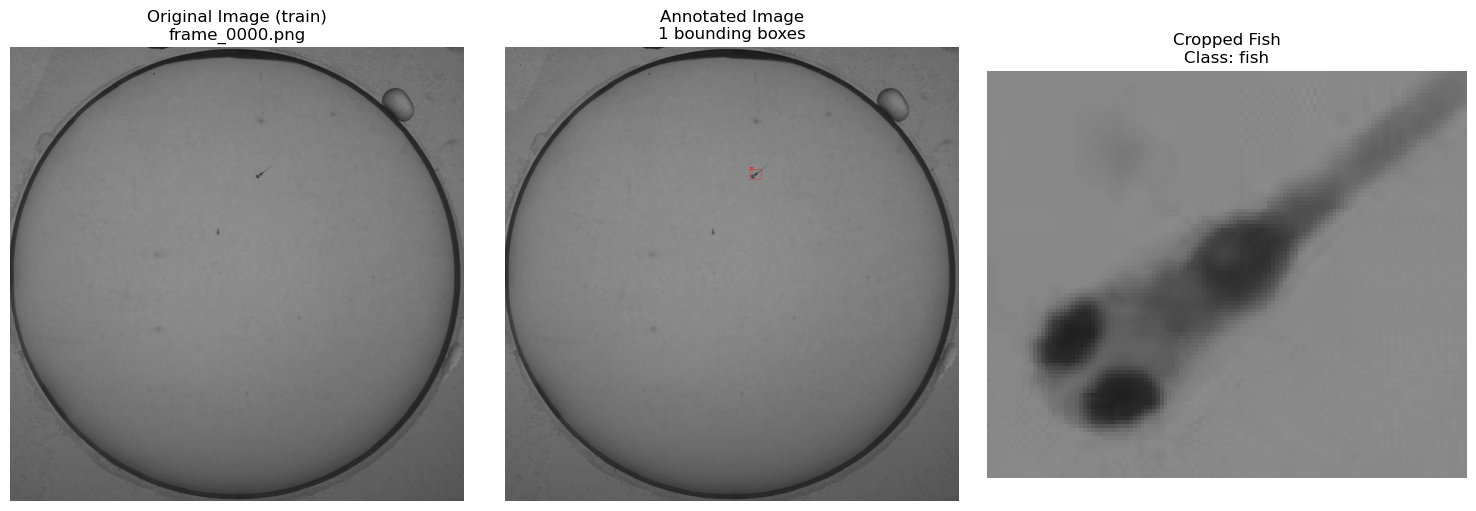

Image 1/5122 | Split: train | File: frame_0000.png
Bounding Box: [2436, 1217, 115, 96] | Class: fish


interactive(children=(IntSlider(value=0, description='Image Index:', layout=Layout(width='70%'), max=5121, sty…

IntSlider(value=0, description='Image Index:', layout=Layout(width='70%'), max=5121, style=SliderStyle(descrip…

In [66]:
def visualize_yolo_dataset(dataset_path, original_images_path):
    """
    Create an interactive widget to visualize YOLO dataset annotations.
    
    Parameters:
    -----------
    dataset_path : str
        Path to the YOLO dataset folder
    original_images_path : str
        Path to the folder containing original images
    """
    # Get all images from the dataset (combining train and val)
    train_images_dir = os.path.join(dataset_path, 'images', 'train')
    val_images_dir = os.path.join(dataset_path, 'images', 'val')
    train_labels_dir = os.path.join(dataset_path, 'labels', 'train')
    val_labels_dir = os.path.join(dataset_path, 'labels', 'val')
    
    train_images = [(os.path.join(train_images_dir, f), os.path.join(train_labels_dir, f.replace('.png', '.txt')), 'train')
                   for f in sorted(os.listdir(train_images_dir)) if f.endswith('.png')]
    
    val_images = [(os.path.join(val_images_dir, f), os.path.join(val_labels_dir, f.replace('.png', '.txt')), 'val')
                 for f in sorted(os.listdir(val_images_dir)) if f.endswith('.png')]
    
    all_images = train_images + val_images
    
    # Load class names
    with open(os.path.join(dataset_path, 'classes.txt'), 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    
    # Create color map for classes (only one class in this case, but extensible)
    colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))
    colors = (colors[:, :3] * 255).astype(int)
    
    def parse_yolo_label(label_path, img_width, img_height):
        """Parse YOLO label file and convert to pixel coordinates"""
        bboxes = []
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        # YOLO format: center_x, center_y, width, height (normalized)
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        # Convert to top-left corner format for OpenCV rectangle
                        x_min = int(x_center - width / 2)
                        y_min = int(y_center - height / 2)
                        x_max = int(x_center + width / 2)
                        y_max = int(y_center + height / 2)
                        
                        bboxes.append((class_id, x_min, y_min, x_max, y_max))
        except Exception as e:
            print(f"Error parsing {label_path}: {e}")
        
        return bboxes
    
    def draw_bboxes(img, bboxes):
        """Draw bounding boxes on the image"""
        img_with_boxes = img.copy()
        
        for class_id, xmin, ymin, xmax, ymax in bboxes:
            color = tuple(map(int, colors[class_id]))
            cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), color, 2)
            
            # Add class label
            label = class_names[class_id]
            text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(img_with_boxes, (xmin, ymin - text_size[1] - 10), (xmin + text_size[0], ymin), color, -1)
            cv2.putText(img_with_boxes, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        return img_with_boxes
    
    def crop_bbox(img, bbox):
        """Crop the image to the bounding box with a small margin"""
        class_id, xmin, ymin, xmax, ymax = bbox
        
        # Add a small margin
        margin = 5
        xmin = max(0, xmin - margin)
        ymin = max(0, ymin - margin)
        xmax = min(img.shape[1], xmax + margin)
        ymax = min(img.shape[0], ymax + margin)
        
        return img[ymin:ymax, xmin:xmax]
    
    def update_image(index):
        """Update the displayed image based on the slider value"""
        if index >= len(all_images):
            return
        
        img_path, label_path, split_type = all_images[index]
        img_filename = os.path.basename(img_path)
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        height, width = img.shape[:2]
        
        # Parse label
        bboxes = parse_yolo_label(label_path, width, height)
        
        # Draw bounding boxes
        img_with_boxes = draw_bboxes(img, bboxes)
        
        # Create figure with subplots
        plt.figure(figsize=(15, 5))
        
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"Original Image ({split_type})\n{img_filename}")
        plt.axis('off')
        
        # Plot image with bounding boxes
        plt.subplot(1, 3, 2)
        plt.imshow(img_with_boxes)
        plt.title(f"Annotated Image\n{len(bboxes)} bounding boxes")
        plt.axis('off')
        
        # Plot cropped bounding boxes
        if bboxes:
            bbox = bboxes[0]  # Get the first bbox (normally there's only one fish)
            cropped = crop_bbox(img, bbox)
            
            plt.subplot(1, 3, 3)
            plt.imshow(cropped)
            plt.title(f"Cropped Fish\nClass: {class_names[bbox[0]]}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Display metadata
        info_text = f"Image {index+1}/{len(all_images)} | Split: {split_type} | File: {img_filename}"
        if bboxes:
            bbox = bboxes[0]
            class_id, xmin, ymin, xmax, ymax = bbox
            width = xmax - xmin
            height = ymax - ymin
            info_text += f"\nBounding Box: [{xmin}, {ymin}, {width}, {height}] | Class: {class_names[class_id]}"
        
        print(info_text)
    
    # Create widgets for interaction
    style = {'description_width': 'initial'}
    slider = widgets.IntSlider(
        min=0, 
        max=len(all_images)-1, 
        step=1, 
        value=0,
        description='Image Index:',
        style=style,
        layout=widgets.Layout(width='70%')
    )
    
    # Add navigation buttons
    prev_button = widgets.Button(description='Previous', layout=widgets.Layout(width='100px'))
    next_button = widgets.Button(description='Next', layout=widgets.Layout(width='100px'))
    
    # Jump to specific split
    split_dropdown = widgets.Dropdown(
        options=['All', 'Train', 'Validation'],
        value='All',
        description='Dataset split:',
        style=style
    )
    
    # Go to specific index
    go_to_input = widgets.IntText(
        value=0,
        description='Go to index:',
        style=style,
        layout=widgets.Layout(width='200px')
    )
    go_button = widgets.Button(
        description='Go',
        layout=widgets.Layout(width='60px')
    )
    
    # Button callbacks
    def on_prev_clicked(b):
        slider.value = max(0, slider.value - 1)
    
    def on_next_clicked(b):
        slider.value = min(len(all_images) - 1, slider.value + 1)
    
    def on_go_clicked(b):
        if 0 <= go_to_input.value < len(all_images):
            slider.value = go_to_input.value
    
    def on_split_change(change):
        # Filter images based on selected split
        train_indices = [i for i, (_, _, split) in enumerate(all_images) if split == 'train']
        val_indices = [i for i, (_, _, split) in enumerate(all_images) if split == 'val']
        
        if change['new'] == 'Train' and train_indices:
            slider.value = train_indices[0]
        elif change['new'] == 'Validation' and val_indices:
            slider.value = val_indices[0]
    
    # Connect callbacks
    prev_button.on_click(on_prev_clicked)
    next_button.on_click(on_next_clicked)
    go_button.on_click(on_go_clicked)
    split_dropdown.observe(on_split_change, names='value')
    
    # Layout
    navigation = widgets.HBox([prev_button, slider, next_button])
    goto_box = widgets.HBox([go_to_input, go_button])
    controls = widgets.VBox([navigation, widgets.HBox([split_dropdown, goto_box])])
    
    # Display widgets and initial image
    display(controls)
    update_image(0)
    
    # Connect slider to update function
    widgets.interact(update_image, index=slider)
    
    return slider

# Usage
dataset_path = "fish_yolo_dataset"
original_images_path = "raw_frames"  # Path to original full frames

visualize_yolo_dataset(dataset_path, original_images_path)

In [60]:
import cv2
import os
from tqdm.notebook import tqdm

def extract_frames_from_video(video_path, output_folder, frame_skip=0, max_frames=None):
    """
    Extract frames from a video file and save them as individual images.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    output_folder : str
        Folder to save the extracted frames
    frame_skip : int
        Number of frames to skip between extractions (0 = extract every frame)
    max_frames : int or None
        Maximum number of frames to extract (None = extract all frames)
    
    Returns:
    --------
    int
        Number of frames extracted
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return 0
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"Video Information:")
    print(f"- Total frames: {total_frames}")
    print(f"- FPS: {fps:.2f}")
    print(f"- Duration: {duration:.2f} seconds")
    
    # Calculate how many frames we'll extract
    frame_count = total_frames
    if frame_skip > 0:
        frame_count = total_frames // (frame_skip + 1) + 1
    if max_frames is not None and max_frames < frame_count:
        frame_count = max_frames
    
    print(f"Extracting up to {frame_count} frames (1 of every {frame_skip + 1})...")
    
    # Extract frames
    extracted_count = 0
    frame_index = 0
    
    # Use tqdm for a progress bar
    with tqdm(total=frame_count) as pbar:
        while True:
            ret, frame = cap.read()
            if not ret or (max_frames is not None and extracted_count >= max_frames):
                break
            
            # Extract this frame if it's not being skipped
            if frame_skip == 0 or frame_index % (frame_skip + 1) == 0:
                frame_filename = f"frame_{extracted_count:04d}.png"
                frame_path = os.path.join(output_folder, frame_filename)
                cv2.imwrite(frame_path, frame)
                extracted_count += 1
                pbar.update(1)
            
            frame_index += 1
    
    # Release resources
    cap.release()
    
    print(f"Extraction complete! Saved {extracted_count} frames to {output_folder}")
    return extracted_count

# Usage
video_path = "one_fish.mp4"  # Path to your video file
output_folder = "raw_frames"  # Folder to save frames
frame_skip = 0  # Extract every frame (set to higher value to skip frames)
max_frames = None  # Extract all frames (set to a number to limit extraction)

# Extract frames from the video
num_frames = extract_frames_from_video(video_path, output_folder, frame_skip, max_frames)

Video Information:
- Total frames: 5457
- FPS: 70.04
- Duration: 77.91 seconds
Extracting up to 5457 frames (1 of every 1)...


  0%|          | 0/5457 [00:00<?, ?it/s]

Extraction complete! Saved 5454 frames to raw_frames
